# Описание проекта

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

### Описание данных

    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек добычи;
    product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
#Загружаем датафреймы
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

#### Посмотрим на первые три строчки датафреймов

In [3]:
data_0.head(3)

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647

In [4]:
data_1.head(3)

id         f0        f1        f2     product
0  kBEdx -15.001348 -8.276000 -0.005876    3.179103
1  62mP7  14.272088 -3.475083  0.999183   26.953261
2  vyE1P   6.263187 -5.948386  5.001160  134.766305

In [5]:
data_2.head(3)

id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697
2  ovLUW  0.194587  0.289035 -5.586433  62.871910

#### Посмотрим частоты целевого признака

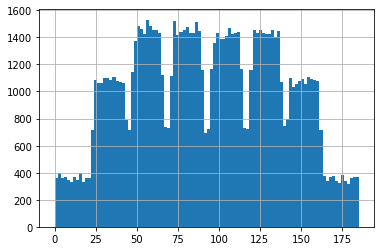

In [6]:
data_0['product'].hist(bins = 100)

In [7]:
data_1['product'].hist(bins = 100)

In [8]:
data_2['product'].hist(bins = 100)

#### Посмотрим корреляцию признаков в датафреймах

In [9]:
print(data_0.corr())
print(data_1.corr())
print(data_2.corr())

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


#### В датафрейме data_1 видна сильная корреляция целевого признака от признака f2.

In [10]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Во всех датафреймах пропусков не обнаружено

## Вывод по шагу 1:
    - данные загружены.
    - пропусков в данных не обнаружено.
    - построены гистограммы частот целевого признака
    - в датафрейме data_1 имеется сильная зависимость целевого признака от признака f2

# 2. Обучение и проверка модели

#### Для выполнения шага 2 используем 2 функция, первая - split_df разделяет выборки на валидационную и тренировочную и разделяет признаки в них, вторая - lin_reg строит модель линейной регрессии и делает предсказания, а также считает заданные метрики

In [13]:
def split_df(df):
    """
    Функция разделяет выделяет из датафрейма тренировочную и валидационную выборки, разделенные на признаки и
    целевой признак.
    """
    #Разделим признаки и целевой признак
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    #Разобьем выборку на тренировочную и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, 
        target,
        test_size=0.25,
        random_state=12345)
    
    return features_train, target_train, features_valid, target_valid

In [14]:
def lin_reg(df):
    """
    Функция строит модель линейной регрессии, обучает ее, считает RMSE и среднюю добычу.
    На выходе функция дает предсказания и правильные ответы.
    """
    #Разделим данные на выборки функцией split_df()
    features_train, target_train, features_valid, target_valid = split_df(df)
    #Строим модель
    model = LinearRegression()
    model.fit(features_train, target_train)
    #Сделаем предсказания
    prediction = model.predict(features_valid)
    prediction = pd.Series(prediction, index=target_valid.index)
    #Считаем среднеквадратичную ошибку и средню добычу с региона
    mse = mean_squared_error(target_valid, prediction)
    rmse = mse ** 0.5
    print('RMSE=', rmse)
    #target_sum = pd.concat([target_train, target_valid], axis=0)
    print('Средний объем сырья в месторождении (по истинным данным), тыс. баррелей -', target_valid.mean())
    print('Средний объем сырья в скважине (по предсказанным данным), тыс. баррелей -', prediction.mean())
    return prediction, target_valid

In [15]:
predictions_0, answers_0 = lin_reg(data_0)

RMSE= 37.5794217150813
Средний объем сырья в месторождении (по истинным данным), тыс. баррелей - 92.07859674082941
Средний объем сырья в скважине (по предсказанным данным), тыс. баррелей - 92.59256778438008


In [16]:
predictions_1, answers_1 = lin_reg(data_1)

RMSE= 0.8930992867756155
Средний объем сырья в месторождении (по истинным данным), тыс. баррелей - 68.72313602437494
Средний объем сырья в скважине (по предсказанным данным), тыс. баррелей - 68.7285468954458


In [17]:
predictions_2, answers_2 = lin_reg(data_2)

RMSE= 40.02970873393434
Средний объем сырья в месторождении (по истинным данным), тыс. баррелей - 94.88423280885489
Средний объем сырья в скважине (по предсказанным данным), тыс. баррелей - 94.96504596800509


## Выводы по шагу 2:
    - данные разделены на обучающую и валидационную выборки в соотношении 75:25
    - выделен целевой признак
    - для каждого региона построена и обучена модель линейной регрессии и сделаны предсказания на валидационной выборке
    - для месторождений первого региона модель предсказывает объем сырья с корнем из среднеквадратичной ошибки (RMSE) = 37,5 тыс.баррелей, при среднем объеме 92 тыс. баррелей
    - для месторождений второго региона модель предсказывает объем сырья с корнем из среднеквадратичной ошибки (RMSE) = 0,89 тыс.баррелей, при среднем объеме месторождения 68,7 тыс. баррелей
    - для месторождений третьего региона модель предсказывает объем сырья с корнем из среднеквадратичной ошибки (RMSE) = 40 тыс.баррелей, при среднем объеме 94.8 тыс. баррелей
    - месторождения первого и третьего регионов имеют больший запас сырья, но модель предсказывает объем хуже чем месторождения второго региона. Запасы сырья второго региона, в свою очередь, примерно на треть беднее
    - качество предсказаний модели второго решина связана с высокой степенью корреляции признака f2 с целевым признаком, выявленной на шаге 1.
    

# 3. Подготовка к расчёту прибыли

In [18]:
EXPLORING_DOTS = 500         # Количество точек исследования
BUDGET = 10 ** 10            # Бюджет на разработку
DRILLING_COST = 5 * 10 ** 7  # Стоимость бурения одной скважины
BARREL_COST = 4500           # Стоимость барреля сырья
RISK_BORDER = 0.025          # Граничное значение риска убытков, выше которого регион не рассматривается

In [19]:
# Количество скважин которое можно пробурить с заданным бюджетом
well_count = int(BUDGET / DRILLING_COST)
well_count

200

#### Исходя из имеющегося бюджета на разработку, в каждом из регионов возможно пробурить не более 200 скважин

In [20]:
# Минимальная требуемая емкость месторождения в тыс. баррелей
well_capacity = (DRILLING_COST / BARREL_COST) * 0.001
well_capacity

11.11111111111111

####  Вывод: Исходя из стоимости бурения и стоимости барреля сырья, для покрытия убытков, связанных с бурением, необходимая емкость сесторождения составляет 11,(1) тыс. баррелей. Месторождения с меньшими запасами будут приносить компании убыток.

In [21]:
def profit(sample, count=well_count):
    """
    Функция на вход принимает значения отобранных предсказаний и количество объектов.
    На выходе функция выдает суммарную прибыль по заданнуму количеству объектов.
    count = 200 (default) - количество отбираемых местарождений
    """
    #Отсортируем по убыванию
    sample_sorted = sample.sort_values(ascending=False)
    #Выбираем count наибольших значений.
    best = sample_sorted[:count]
    #Возвращаемое значение - суммарный предсказанный объем сырья в 200-х лучших месторождениях, умноженный
    #на цену барреля, за вычетом бюджета на разработку.
    return (best.sum() * BARREL_COST * 1000 - BUDGET)

## Вывод по шагу 3:
    - в коде зафиксированы условия задачи
    - рассчитано количество скважен, которое возможно пробурить, исходя из бюджета
    - рассчитан критерий убыточности месторождения - емкость не должне быть меньше 11,111 тыс. баррелей
    - подготовлена функция для расчета прибыли при разработке 200 лучших месторождений из числа 500 исследованных.
    

# 4. Расчёт прибыли и рисков 

#### Для расчета рисков используется функция, оценивающая процент потенциально убыточных месторождений (C отрицательной прибылью)

In [22]:
def risk(sample):
    """
    Функция расчитывает процент отрицательных значений в выборке
    """
    risk_percent = sample[sample < 0].count()/len(sample)
    return risk_percent*100

#### Воспользуемся методом bootstrap для анализа прибыли регионов.

In [23]:
def bootstrap(samples, samples_count=EXPLORING_DOTS, count=well_count):
    """
    Функция проводит расчет средней прибыли от региона добычи и 95%-го доверительного интервала
    samples_count = 500 (default) - величина сэмплируемой выборки
    count = 200 (default) - количество отобираемых месторождений
    
    """
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        subsample = samples.sample(
            n=samples_count, 
            replace=True, 
            random_state=state)
        
        prof = profit(subsample, count)
        values.append(prof)
     
    values = pd.Series(values)
    #Оценим риск убытков, если более 2,5% - регион не рассматривается
    if risk(values) > (RISK_BORDER * 100):
        print('Риск убытков больше граничного значения в 2,5%, регион не рассматривается')
        return
    
    print('Риск убытков составляет {:.2f}'.format(risk(values)))
    print()
    mean_values = values.mean()    
    conf_int_values = st.t.interval(alpha = 0.95, df = (len(values)-1), loc=mean_values, scale=values.sem())
    print("Средняя прибыль региона - {:.2f} млрд. рублей".format(mean_values / 10**9))
    print()
    print("95% доверительный интервал - ({:.2f}, {:.2f}), млрд. рублей"
          .format((conf_int_values[0]/10**9), (conf_int_values[1]/10**9)))

In [24]:
bootstrap(predictions_0)

Риск убытков составляет 0.00

Средняя прибыль региона - 93.58 млрд. рублей

95% доверительный интервал - (93.51, 93.65), млрд. рублей


In [25]:
bootstrap(predictions_1)

Риск убытков составляет 0.00

Средняя прибыль региона - 94.54 млрд. рублей

95% доверительный интервал - (94.41, 94.67), млрд. рублей


In [26]:
bootstrap(predictions_2)

Риск убытков составляет 0.00

Средняя прибыль региона - 92.81 млрд. рублей

95% доверительный интервал - (92.75, 92.88), млрд. рублей


## Вывод по шагу 4:
    - написаны функции расчета рисков выборки, региона
    - методом bootstrap подготовлены подвыборки (1000 шт) и проведен расчет риска убытков, средней рпибыли от 200 выбранных месторождений региона, 95% доверительный интервал прибыли.
    - первый регион имеет риск убытков 0%, среднюю прибыль - 93,58 млрд. рублей и 95% доверительный интервал 93,51 - 93,65 млрд. рублей.
    - второй регион имеет риск убытков 0%, среднюю прибыль - 94.54 млрд. рублей и 95% доверительный интервал 94,41 - 94,67 млрд. рублей.
    - третий регион имеет риск убытков 0%, средняя прибыль - 92,81 млрд. рублей и 95% доверительный интервал 92,75 - 92,88 млрд. рублей.
    

## Общий вывод.
    1. Проведена подготовка данных к построению моделей.
    2. Были построены и обучены модели линейной регрессии для трех регионов добычи.
    3. На валидационных выборках были проведены предсказания:
        - RMSE модели первого региона составило 37,5 тыс.баррелей, при среднем объеме 92 тыс. баррелей
        - RMSE модели второго региона составило 0,89 тыс.баррелей, при среднем объеме месторождения 68,7 тыс. баррелей
        - RMSE модели третьего региона составило 40 тыс.баррелей, при среднем объеме 94.8 тыс. баррелей
    4. Расчитано количество месторождений, которая компания может разработать исходя из бюджета - 200 шт.
    5. Расчитано минимальное объем сырья в месторождении для того чтобы оно не было убыточным - 11,111 тыс. баррелей.
    6. Проведен расчет рисков и прыбыли для каждого региона, он показал:
        - риск убытков всех регионов меньше заданного значения в 2,5%
        - средняя прибыль от месторождений первого региона составляет 93,58 млрд. рублей и 95% доверительный интервал 93,51 - 93,65 млрд. рублей
        - средняя прибыль от месторождений второго региона составляет 94.54 млрд. рублей и 95% доверительный интервал 94,41 - 94,67 млрд. рублей
        - средняя прибыль от месторождений третьего региона составляет 92,81 млрд. рублей и 95% доверительный интервал 92,75 - 92,88 млрд. рублей
    7. Исходня из того что средняя прибыль месторождений второго региона больше средней прибыли месторождений первого и третьего региона, нижняя граница 95%-го доверительного интервала больше верхней границы интервала у первого и третьего регионов, и низких рисков убытков всех трех регионов, для разработки рекомендуются месторождения второго региона.
        